In [1]:
##################################################
# 不要修改此单元格中的代码
##################################################

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader


def count_parameters(model):
    total = sum([param.nelement() for param in model.parameters()])
    print("Number of parameter: %.2fM" % (total / 1e6))
    return total


class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def train_epoch(net, train_iter, loss_fn, optimizer):
    net.train()
    device = next(net.parameters()).device
    metrics = Accumulator(4)
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metrics.add(loss * len(y), accuracy(y_hat, y) * len(y), len(y))
        train_loss = metrics[0] / metrics[2]
        train_acc = metrics[1] / metrics[2]
    return train_loss, train_acc


@torch.no_grad()
def eval_model(net, test_iter, loss_fn):
    net.eval()
    device = next(net.parameters()).device
    metrics = Accumulator(3)
    for X, y in test_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        loss = loss_fn(y_hat, y)
        metrics.add(loss * len(y), accuracy(y_hat, y) * len(y), len(y))
    test_loss = metrics[0] / metrics[2]
    test_acc = metrics[1] / metrics[2]
    return test_loss, test_acc


def accuracy(y_hat, y_true):
    y_pred = y_hat.argmax(dim=1)
    return (y_pred == y_true).float().mean().item()


logging_columns_list = ["epoch", "train_loss", "test_loss", "train_acc", "test_acc"]


def print_columns(columns_list=logging_columns_list, is_head=False, is_final_entry=False):
    print_string = ""
    for col in columns_list:
        print_string += "|  %s  " % col
    print_string += "|"
    if is_head:
        print("-" * len(print_string))
    print(print_string)
    if is_head or is_final_entry:
        print("-" * len(print_string))


def print_training_details(variables, is_final_entry):
    formatted = []
    for col in logging_columns_list:
        var = variables.get(col.strip(), None)
        if type(var) in (int, str):
            res = str(var)
        elif type(var) is float:
            res = "{:0.4f}".format(var)
        else:
            assert var is None
            res = ""
        formatted.append(res.rjust(len(col)))
    print_columns(formatted, is_final_entry=is_final_entry)

In [2]:
import torchvision.transforms as T


def load_data(root="cifar10", batch_size=64):
    MEAN = (0.4914, 0.4822, 0.4465)
    STD = (0.2023, 0.1994, 0.2010)
    train_trans = T.Compose(
        [
            T.RandomCrop(32, padding=4),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize(MEAN, STD),
        ]
    )
    test_trans = T.Compose([T.ToTensor(), T.Normalize(MEAN, STD)])

    train_data = torchvision.datasets.CIFAR10(root=root, train=True, download=False, transform=train_trans)
    test_data = torchvision.datasets.CIFAR10(root=root, train=False, download=False, transform=test_trans)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, test_loader

In [3]:
##################################################
# 在此填入你设计的网络模型, 并展示模型参数量
##################################################


class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=4096, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model_test = CifarNet()
count_parameters(model_test)

x_test = torch.randn(20, 3, 32, 32)
y_test = model_test(x_test)
assert y_test.shape == torch.Size([20, 10]), f"Expected output shape: [20, 10], but got {y_test.shape}"

Number of parameter: 5.85M


In [4]:
from tqdm import tqdm


def train_cifar(config):
    epochs = config["epochs"]
    batch_size = config["batch_size"]
    lr = config["lr"]
    train_loader, test_loader = load_data("cifar10", batch_size)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CifarNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    best_acc = 0
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer)
        test_loss, test_acc = eval_model(model, test_loader, loss_fn)
        if test_acc > best_acc:
            best_acc = test_acc
    return best_acc

In [5]:
import optuna


def objective(trial):
    config = {
        "batch_size": 512,
        "lr": trial.suggest_float("lr", 1e-5, 0.01, log=True),
        "best_acc": 0,  # 记录最佳准确率
        "epochs": 20,
    }
    # 目标函数为测试集准确率
    test_acc = train_cifar(config)
    return test_acc


study = optuna.create_study(direction="maximize")  # 最大化准确率
study.optimize(objective, n_trials=10)  # 运行 10 次试验

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

results_df = study.trials_dataframe()
results_df.to_csv("baseline.csv", index=False)

[I 2024-05-12 20:42:37,399] A new study created in memory with name: no-name-59925b56-421d-4894-86ad-ab9ce3efb45f
100%|██████████| 20/20 [01:53<00:00,  5.67s/it]
[I 2024-05-12 20:44:31,502] Trial 0 finished with value: 0.7228999996185302 and parameters: {'lr': 0.00016899707936745753}. Best is trial 0 with value: 0.7228999996185302.
100%|██████████| 20/20 [01:53<00:00,  5.65s/it]
[I 2024-05-12 20:46:25,163] Trial 1 finished with value: 0.7972000005722046 and parameters: {'lr': 0.002242230538311569}. Best is trial 1 with value: 0.7972000005722046.
100%|██████████| 20/20 [01:53<00:00,  5.65s/it]
[I 2024-05-12 20:48:18,862] Trial 2 finished with value: 0.8537999998092651 and parameters: {'lr': 0.0009396035606708797}. Best is trial 2 with value: 0.8537999998092651.
100%|██████████| 20/20 [01:53<00:00,  5.66s/it]
[I 2024-05-12 20:50:12,678] Trial 3 finished with value: 0.45710000014305113 and parameters: {'lr': 1.1603282783404595e-05}. Best is trial 2 with value: 0.8537999998092651.
100%|███

Best trial:
  Value:  0.8537999998092651
  Params: 
    lr: 0.0009396035606708797


In [6]:
import pandas as pd

results_df = pd.read_csv("baseline.csv")
results_df = results_df.sort_values(by="value", ascending=False)
results_df.head(5)

,number,value,datetime_start,datetime_complete,duration,params_lr,state
2,2,0.8538,2024-05-12 20:46:25.163932,2024-05-12 20:48:18.861973,0 days 00:01:53.698041,0.000940,COMPLETE
6,6,0.8441,2024-05-12 20:54:00.019985,2024-05-12 20:55:53.790079,0 days 00:01:53.770094,0.001060,COMPLETE
4,4,0.8375,2024-05-12 20:50:12.678961,2024-05-12 20:52:06.327714,0 days 00:01:53.648753,0.000472,COMPLETE
1,1,0.7972,2024-05-12 20:44:31.502556,2024-05-12 20:46:25.163447,0 days 00:01:53.660891,0.002242,COMPLETE
9,9,0.7686,2024-05-12 20:59:41.467426,2024-05-12 21:01:35.074973,0 days 00:01:53.607547,0.000246,COMPLETE


In [9]:
opt_cfg = results_df.iloc[0].to_dict()
epochs = 20
batch_size = 512
lr = opt_cfg["params_lr"]

train_loader, test_loader = load_data("cifar10", batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CifarNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

train_ls, test_ls, train_acc_ls, test_acc_ls = [], [], [], []
print_columns(is_head=True)
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer)
    test_loss, test_acc = eval_model(model, test_loader, loss_fn)
    print_training_details(locals(), is_final_entry=True if epoch == epochs else False)
    train_ls.append(train_loss)
    test_ls.append(test_loss)
    train_acc_ls.append(train_acc)
    test_acc_ls.append(test_acc)

-------------------------------------------------------------------
|  epoch  |  train_loss  |  test_loss  |  train_acc  |  test_acc  |
-------------------------------------------------------------------
|      1  |      1.9437  |     1.6050  |     0.2636  |    0.3863  |
|      2  |      1.5159  |     1.3277  |     0.4319  |    0.5075  |
|      3  |      1.2370  |     1.0921  |     0.5457  |    0.6024  |
|      4  |      1.0512  |     0.9810  |     0.6195  |    0.6490  |
|      5  |      0.9441  |     0.8972  |     0.6619  |    0.6848  |
|      6  |      0.8190  |     0.7775  |     0.7087  |    0.7271  |
|      7  |      0.7465  |     0.7284  |     0.7352  |    0.7461  |
|      8  |      0.6937  |     0.6660  |     0.7534  |    0.7712  |
|      9  |      0.6418  |     0.6403  |     0.7734  |    0.7787  |
|     10  |      0.5838  |     0.6091  |     0.7955  |    0.7940  |
|     11  |      0.5445  |     0.5744  |     0.8106  |    0.8041  |
|     12  |      0.5134  |     0.5439  |     0.8

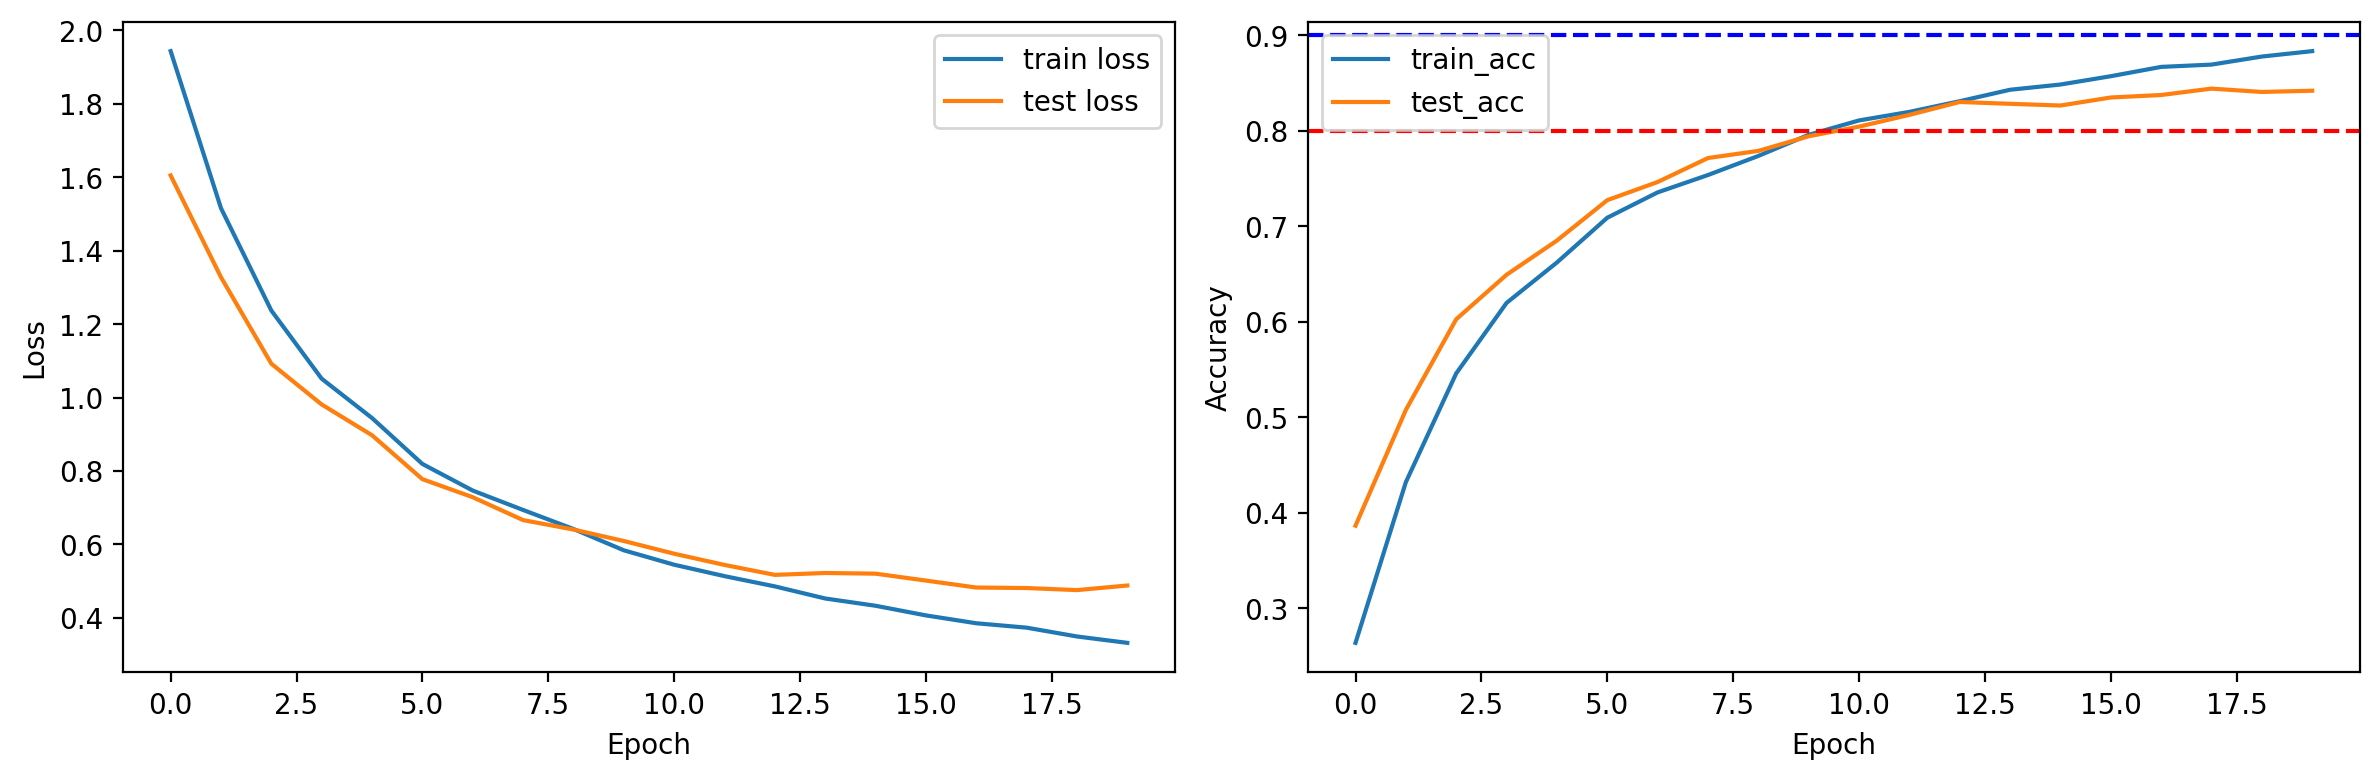

Best test accuaracy:  0.8439000001907349


In [11]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# 绘制第一个子图
axs[0].plot(train_ls, label="train loss")
axs[0].plot(test_ls, label="test loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# 绘制第二个子图
axs[1].plot(train_acc_ls, label="train_acc")
axs[1].plot(test_acc_ls, label="test_acc")
axs[1].axhline(y=0.8, color='r', linestyle='--')  # 添加 y=0.8 的参考线
axs[1].axhline(y=0.9, color='b', linestyle='--')  # 添加 y=0.9 的参考线
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()
print("Best test accuaracy: ", max(test_acc_ls))